Epoch 1, Loss: 0.1403
Epoch 2, Loss: 0.0865
Epoch 3, Loss: 0.0609
Epoch 4, Loss: 0.0868
Epoch 5, Loss: 0.0624
Epoch 6, Loss: 0.0401
Epoch 7, Loss: 0.0617
Epoch 8, Loss: 0.0506
Epoch 9, Loss: 0.0630
Epoch 10, Loss: 0.0574


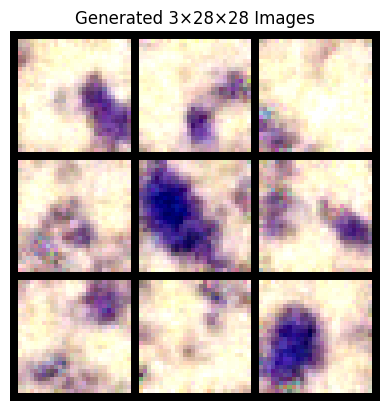

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO

import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset

# ========================
# DDPM Components
# ========================

def get_beta_schedule(timesteps, start=1e-4, end=0.02):
    return torch.linspace(start, end, timesteps)

# Noise schedule
T = 1000
betas = get_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# ========================
# U-Net like Model
# ========================

class SimpleDDPM(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.time_embed = nn.Embedding(T, 128)
        self.net = nn.Sequential(
            nn.Conv2d(channels + 1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, channels, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        #t_emb = self.time_embed(t).view(-1, 1, 1, 128).repeat(1, 1, x.shape[2], x.shape[3])
        #t_channel = t_emb[:, :, :, 0].unsqueeze(1)  # Just one channel of the embedding
        t_channel = t_emb[:, 0].view(-1, 1, 1, 1).expand(-1, 1, x.shape[2], x.shape[3])
        x_in = torch.cat([x, t_channel], dim=1)
        return self.net(x_in)

# ========================
# Forward Process
# ========================

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = alphas_cumprod[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = (1 - alphas_cumprod[t]).sqrt().view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise

# ========================
# Training Loop (Dummy Data)
# ========================

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleDDPM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Dummy dataset: 3x28x28 images
def get_fake_data(batch_size=64):
    return torch.rand(batch_size, 3, 28, 28) * 2 - 1


#####################################################################

data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalize to [-1, 1]
])

# Load all splits
train = DataClass(split='train', transform=transform, download=True)
val = DataClass(split='val', transform=transform, download=True)
test = DataClass(split='test', transform=transform, download=True)

# Combine them into a single dataset
full_dataset = ConcatDataset([train, val, test])
full_dataloader = DataLoader(full_dataset, batch_size=128, shuffle=True)

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test, batch_size=128, shuffle=True)

#####################################################################



# Training loop (very short for demo)
for epoch in range(10):
    #model.train()
    for x0, _ in full_dataloader:  # batches
        #x0 = get_fake_data(64)
        t = torch.randint(0, T, (x0.size(0),), device="cpu").long()
        noise = torch.randn_like(x0)
        x_noisy = q_sample(x0, t, noise)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# ========================
# Sampling
# ========================

@torch.no_grad()
def sample(model, num_samples=16):
    model.eval()
    x = torch.randn(num_samples, 3, 28, 28)
    for t in reversed(range(T)):
        t_batch = torch.full((num_samples,), t, device="cpu", dtype=torch.long)
        z = torch.randn_like(x) if t > 0 else 0
        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]

        pred_noise = model(x, t_batch)
        x = (1 / alpha.sqrt()) * (
            x - ((1 - alpha) / (1 - alpha_cumprod).sqrt()) * pred_noise
        ) + beta.sqrt() * z
    return x

samples = sample(model, num_samples=9).cpu()
grid = torchvision.utils.make_grid(samples, nrow=3, normalize=True, value_range=(-1, 1))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated 3×28×28 Images")
plt.show()